In [1]:
require(tidyverse)
require(rpart)
require(glmnet)
require(zoo)
library(corrplot)
require(rpart)
require(randomForest)
require(partykit)
require(pROC)

Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: rpart

Loading required package: glmnet

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 3.0-2


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'corrplot' was built under R 

# DATA IMPORT

In [2]:
data <- read.csv("dengue_features_train.csv")
target <- read.csv("dengue_labels_train.csv")
test <- read.csv("dengue_features_test.csv")
submission <- test[,c(1,2,3)]

# Exploratory Data Analysis

In [3]:
S <- arrange(target,desc(total_cases))
T <- group_by(S,city)
arrange(summarise(T,count = n(),cases_percity = sum(total_cases)),cases_percity)

city,count,cases_percity
<fct>,<int>,<int>
iq,520,3934
sj,936,31993


In [4]:
S <- arrange(target,year)
T <- group_by(S,year)
arrange(summarise(T,cases_peryear = sum(total_cases)),desc(cases_peryear))

year,cases_peryear
<int>,<int>
1994,6533
1998,4595
1991,2801
1992,2371
2007,2334
2005,2116
1999,1633
2001,1477
1997,1454


In [5]:
A<- group_by(target,weekofyear)
arrange(A,desc(total_cases))

city,year,weekofyear,total_cases
<fct>,<int>,<int>,<int>
sj,1994,41,461
sj,1994,40,426
sj,1994,45,410
sj,1994,39,395
sj,1994,42,381
sj,1994,46,364
sj,1994,47,359
sj,1994,44,353
sj,1994,43,333


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



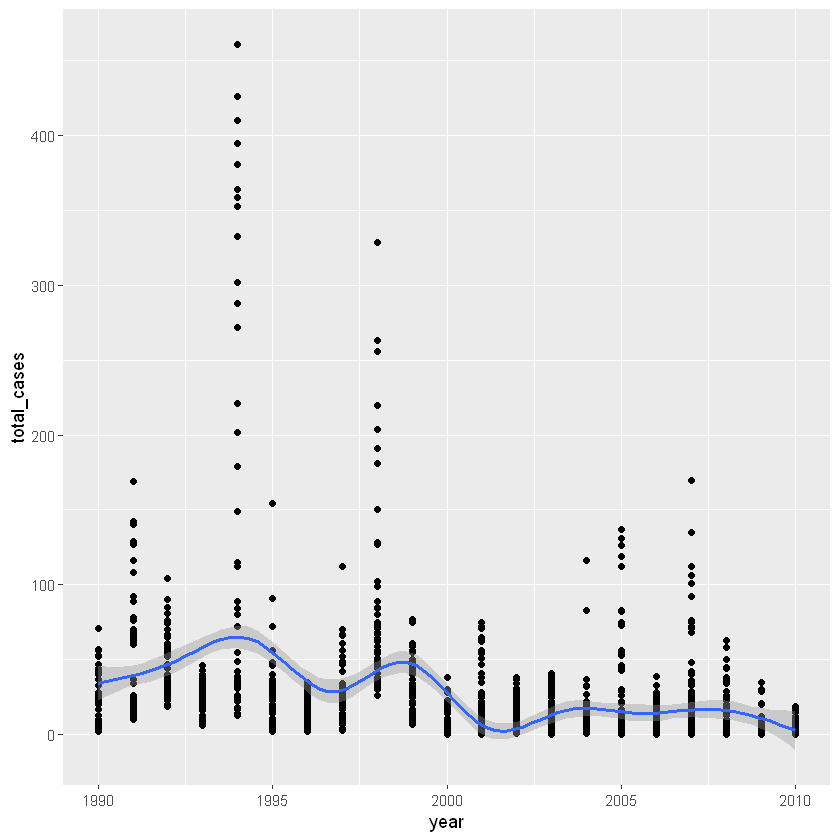

In [6]:
ggplot(target,aes(x = year,y = total_cases))+
geom_point()+geom_smooth()

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



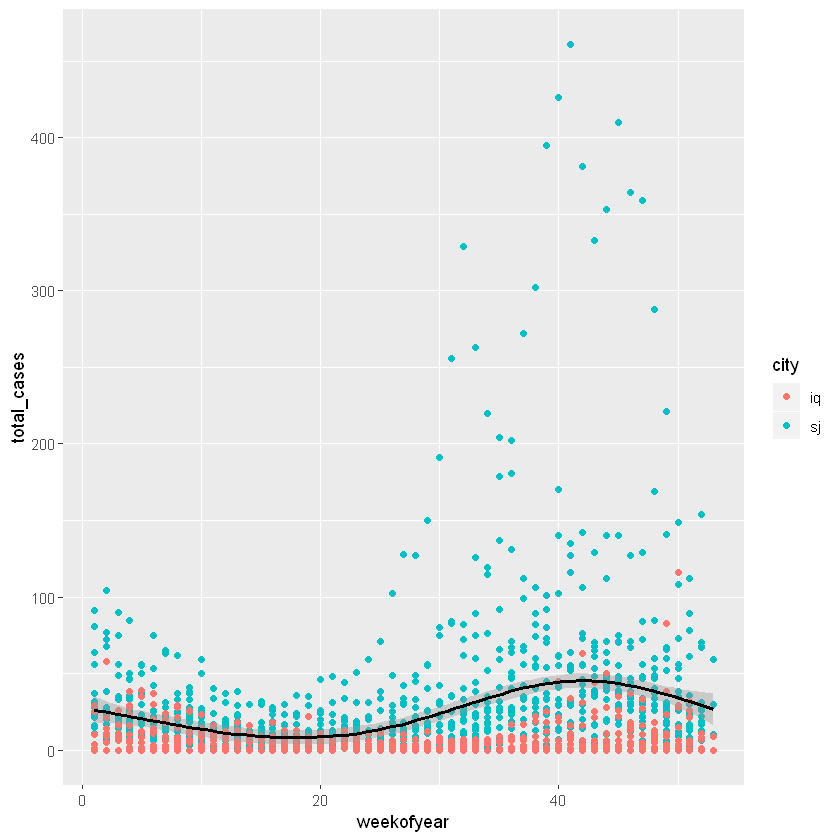

In [7]:
ggplot(target,aes(x = weekofyear,y = total_cases,col = city)) + geom_point() + geom_smooth(col = "black")

# DATA CLEANING

In [8]:
data.frame(NA_data_set = (colSums(is.na(data))/nrow(data)*100), NA_test_set = (colSums(is.na(test))/nrow(test)*100))

,NA_data_set,NA_test_set
,<dbl>,<dbl>
city,0.0000000,0.0000000
year,0.0000000,0.0000000
weekofyear,0.0000000,0.0000000
week_start_date,0.0000000,0.0000000
ndvi_ne,13.3241758,10.3365385
ndvi_nw,3.5714286,2.6442308
ndvi_se,1.5109890,0.2403846
ndvi_sw,1.5109890,0.2403846
precipitation_amt_mm,0.8928571,0.4807692


Fill NA value

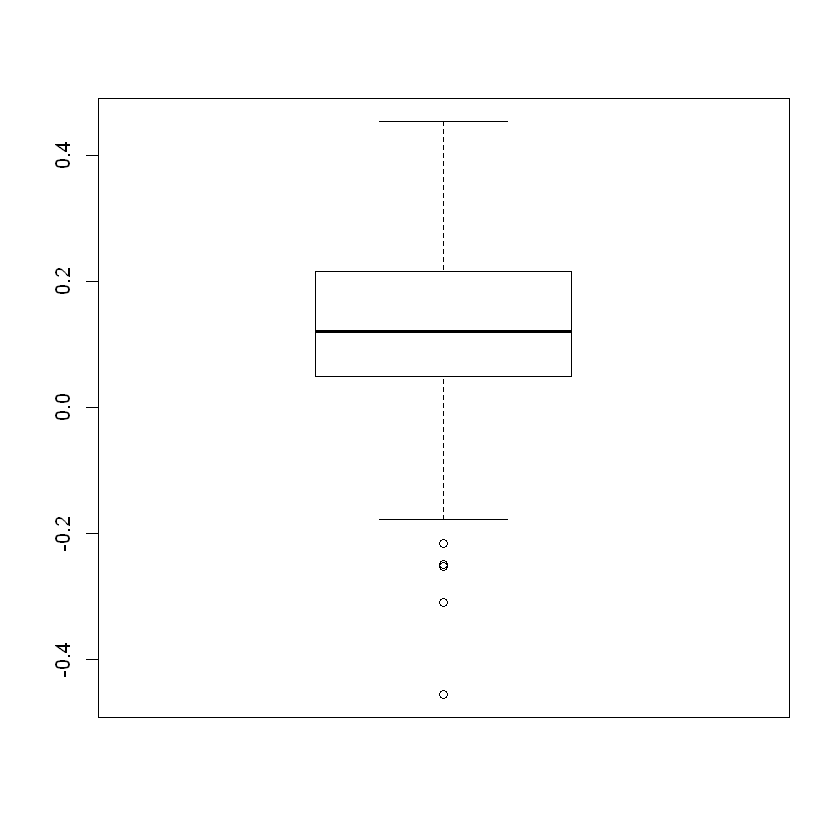

In [9]:
boxplot(x=data$ndvi_nw,y=target$total_cases)

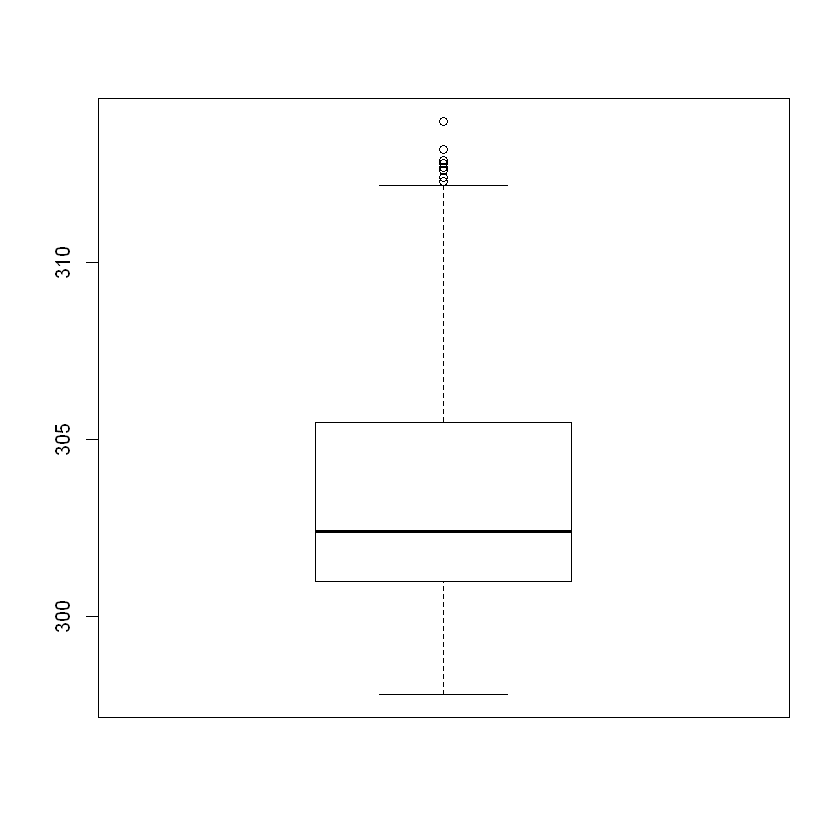

In [10]:
boxplot(x=data$reanalysis_max_air_temp_k,y=target$total_cases)

In [11]:
data <- na.locf(data,fromLast=TRUE)
test <- na.locf(test,fromLast=TRUE)

In [12]:
data.frame(NA_data_set = (colSums(is.na(data))/nrow(data)*100), NA_test_set = (colSums(is.na(test))/nrow(test)*100))

,NA_data_set,NA_test_set
,<dbl>,<dbl>
city,0,0
year,0,0
weekofyear,0,0
week_start_date,0,0
ndvi_ne,0,0
ndvi_nw,0,0
ndvi_se,0,0
ndvi_sw,0,0
precipitation_amt_mm,0,0


Find strong correlation

In [13]:
total <- merge(target,data,by=c("city","year","weekofyear"))

In [78]:
total

,city,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_kgm2,relative_humidity,sat_precipitation,max_temperature,min_temperature,total_precipitation,mosquito
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,iq,26,0.0000000,0.19288570,0.13225710,0.3408857,0.24720000,43.19,92.41857,25.41,32.5,20.7,3.0,1
2,iq,27,0.0000000,0.21683330,0.27610000,0.2894571,0.24165710,46.00,93.58143,60.61,34.0,20.8,55.6,1
3,iq,28,0.0000000,0.17675710,0.17312860,0.2041143,0.12801430,64.77,95.84857,55.52,33.0,20.7,38.1,1
4,iq,29,0.0000000,0.22772860,0.14542860,0.2542000,0.20031430,23.96,87.23429,5.60,31.5,14.7,30.0,2
5,iq,30,0.0000000,0.32864290,0.32212860,0.2543714,0.36104290,31.80,88.16143,62.76,33.3,19.1,4.0,2
6,iq,31,0.0000000,0.20552860,0.19075710,0.2316714,0.25531430,1.00,74.72857,16.24,32.0,17.0,11.5,2
7,iq,32,0.0000000,0.31248570,0.32998570,0.3805857,0.38727140,26.68,83.27571,89.37,34.0,19.9,72.9,2
8,iq,33,0.0000000,0.38413330,0.39224000,0.3417800,0.38275000,16.90,82.49000,42.08,33.0,20.5,50.1,1
9,iq,34,0.0000000,0.40815710,0.32215710,0.4067143,0.30271430,5.59,74.74000,49.22,34.0,19.0,89.2,2


In [14]:
corr <- cor(total[,c(-1,-2,-5)])

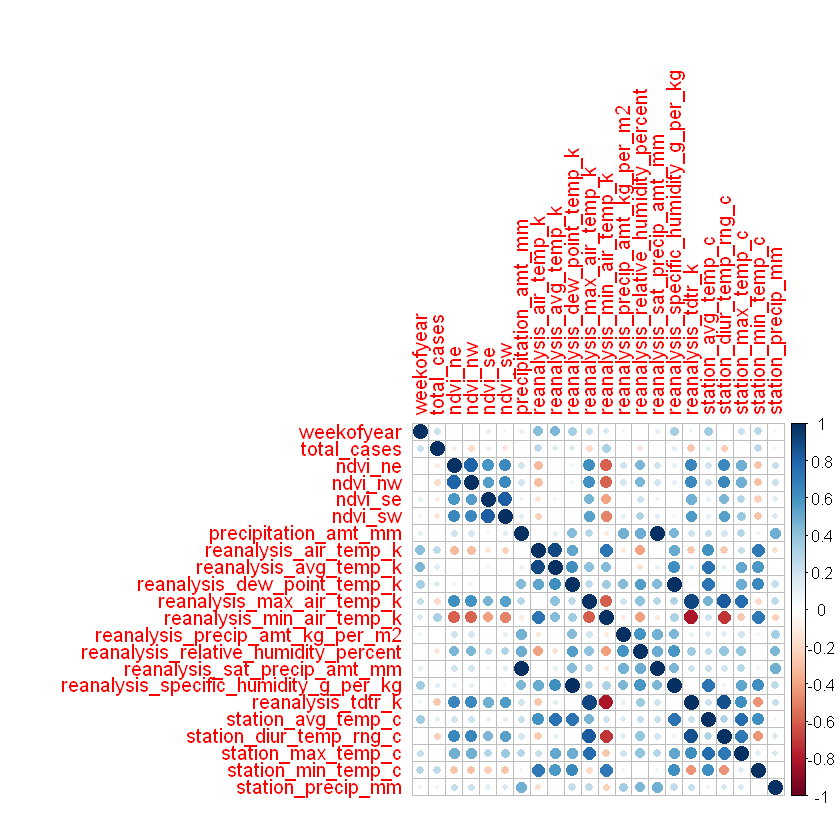

In [15]:
corrplot(corr)

In [80]:
which(corr[1:21,2]>0.5 | corr[1:21,2]< -0.5) #no high correlationship with response

total_cases 
          2

In [84]:
wdbc.pr <- prcomp(total[c(3:13)], center = TRUE, scale = TRUE)
summary(wdbc.pr)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.0583 1.4353 1.0683 0.90626 0.82377 0.75587 0.68953
Proportion of Variance 0.3851 0.1873 0.1037 0.07466 0.06169 0.05194 0.04322
Cumulative Proportion  0.3851 0.5724 0.6762 0.75083 0.81253 0.86446 0.90769
                           PC8    PC9   PC10    PC11
Standard deviation     0.59634 0.5500 0.4437 0.40058
Proportion of Variance 0.03233 0.0275 0.0179 0.01459
Cumulative Proportion  0.94002 0.9675 0.9854 1.00000

In [87]:
wdbc.pr$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
total_cases,0.2331218,-0.17051457,-0.42918305,-0.61941040,0.25486111,-0.40972413,-0.199299445,0.22336652,-0.16121527,0.01424337,0.008805756
ndvi_ne,-0.4081817,0.14814211,-0.10432057,0.01893325,0.14975412,-0.36051400,-0.008385723,-0.33157712,0.20459572,0.64992606,-0.271158157
ndvi_nw,-0.4042551,0.15798061,-0.09656047,0.05541645,0.18528355,-0.38942304,-0.024252672,-0.28456228,0.17252448,-0.63171840,0.320699285
ndvi_se,-0.3353691,0.29719747,-0.16475428,-0.39620493,-0.16594812,0.39771866,0.043942072,0.04620417,-0.04669329,0.25422003,0.598737170
ndvi_sw,-0.3767763,0.26731366,-0.14472727,-0.29489349,-0.07568128,0.29801814,0.001229474,0.12026479,-0.08669119,-0.32307391,-0.676590846
precipitation_kgm2,-0.2153210,-0.45425944,0.11393577,-0.11221511,0.52605067,0.30980574,0.112982566,0.23592380,0.52945485,0.00225406,0.015815266
relative_humidity,-0.3336841,-0.33867974,0.08540864,0.08936302,0.30320087,0.03288641,0.269935783,-0.09695234,-0.76192736,0.03706982,0.038544943
sat_precipitation,-0.2192640,-0.45604338,0.08347926,-0.05938775,-0.27477429,0.13252981,-0.753996633,-0.26520275,-0.03646754,-0.01446156,0.002130891
max_temperature,-0.2912695,-0.08573326,-0.46473055,0.51123868,-0.15474660,-0.10841110,-0.132352302,0.60874867,-0.01139753,0.05845223,0.055984961
min_temperature,0.1465211,-0.32828328,-0.65852754,0.06691982,-0.18975862,0.22349402,0.341869156,-0.45667852,0.12380411,-0.06046233,-0.047476439


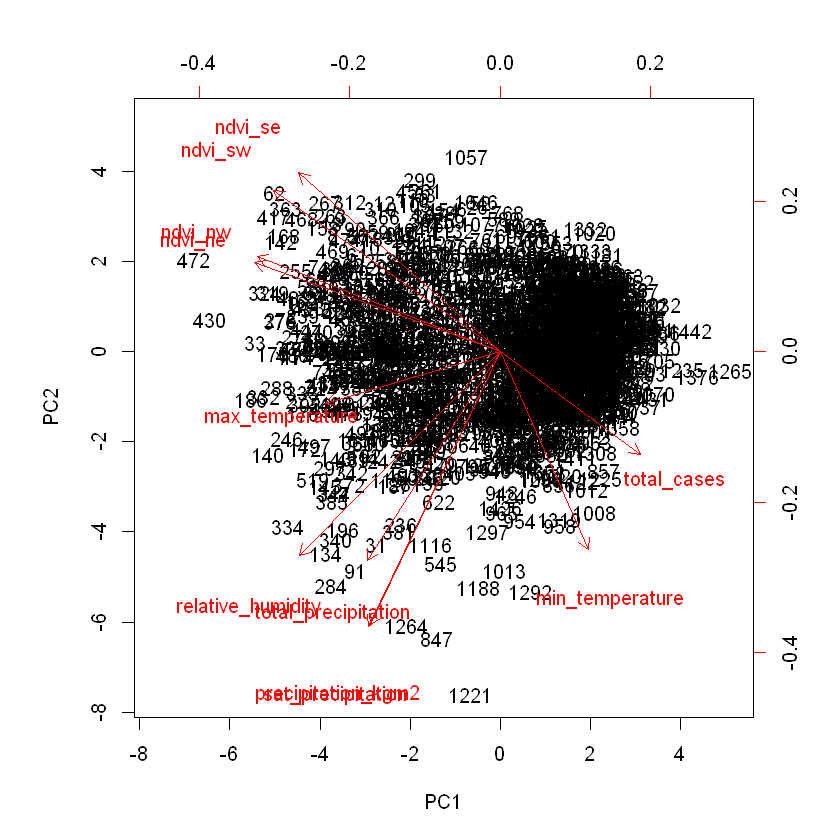

In [86]:
biplot(wdbc.pr, scale = 0)

choose the best variables

In [17]:
total <- total[,-c(10,11,12,13,14,15,19,20,21,22)]
test <- test[,-c(9,10,11,12,13,14,18,19,20,21)]

In [18]:
colnames(total)<-c("city","year","weekofyear","total_cases","week_start_date","ndvi_ne",'ndvi_nw','ndvi_se','ndvi_sw','precipitation_kgm2','relative_humidity','sat_precipitation','max_temperature','min_temperature','total_precipitation')
colnames(test)<-c("city","year","weekofyear","week_start_date","ndvi_ne",'ndvi_nw','ndvi_se','ndvi_sw','precipitation_kgm2','relative_humidity','sat_precipitation','max_temperature','min_temperature','total_precipitation')

Detect outlier

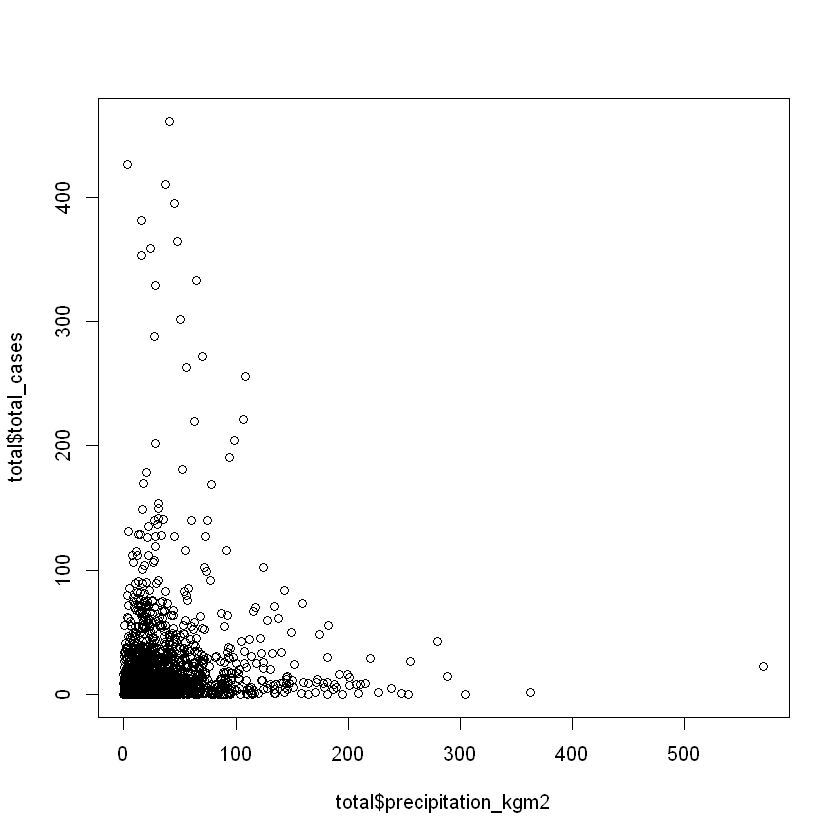

In [19]:
plot(x=total$precipitation_kgm2,y=total$total_cases)

In [20]:
total<-total[-which(total$precipitation_kgm2>500),]

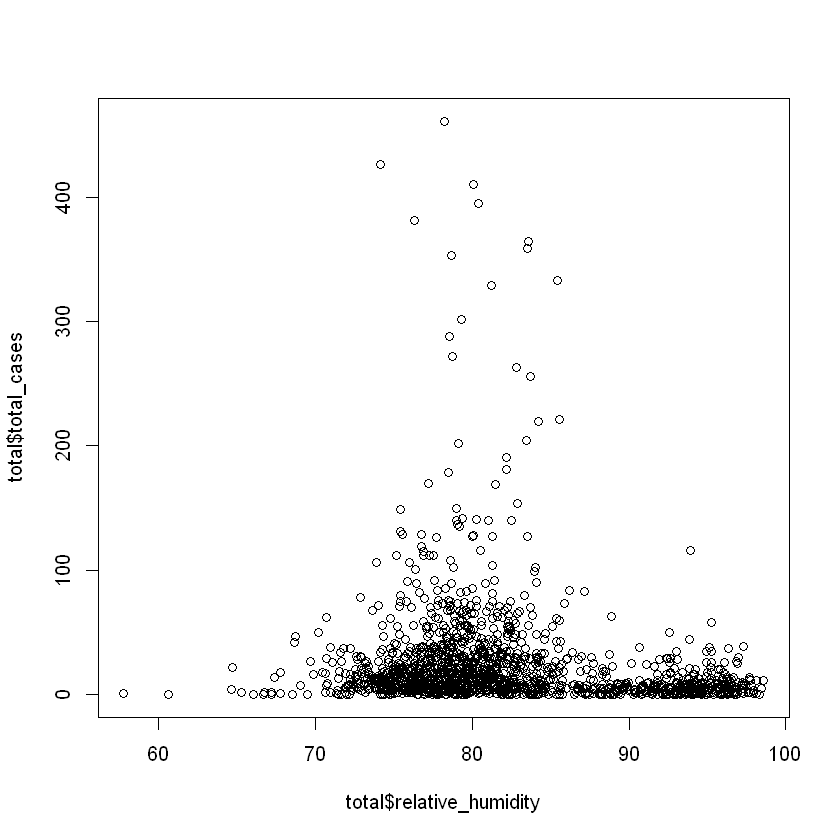

In [21]:
plot(x=total$relative_humidity,y=total$total_cases)

In [22]:
total<-total[-which(total$relative_humidity>90&total$total_cases>100),]

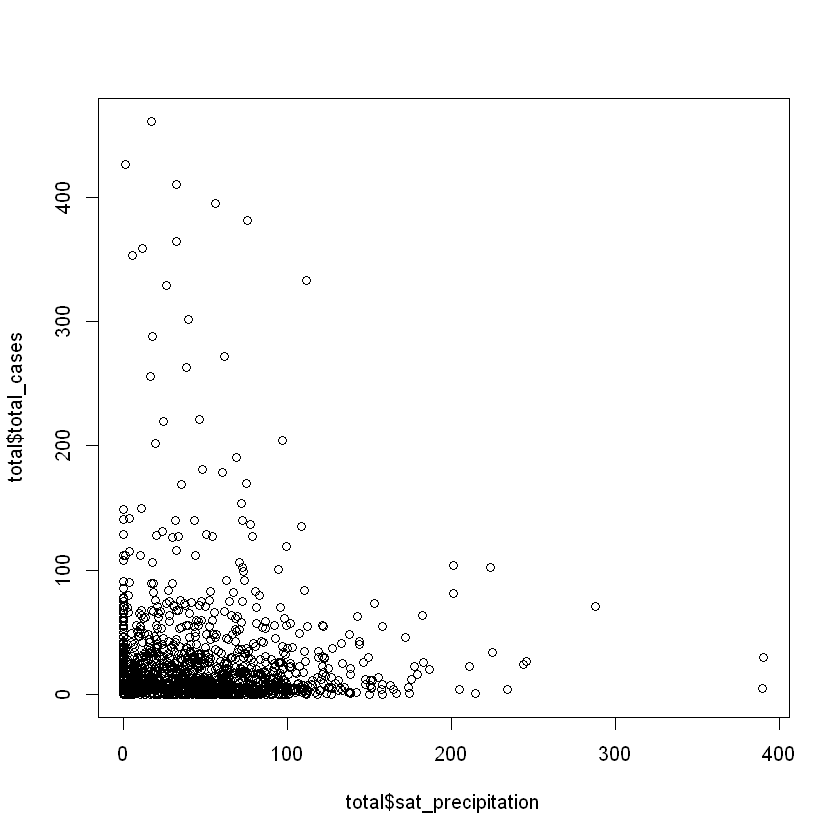

In [23]:
plot(x=total$sat_precipitation,y=total$total_cases)

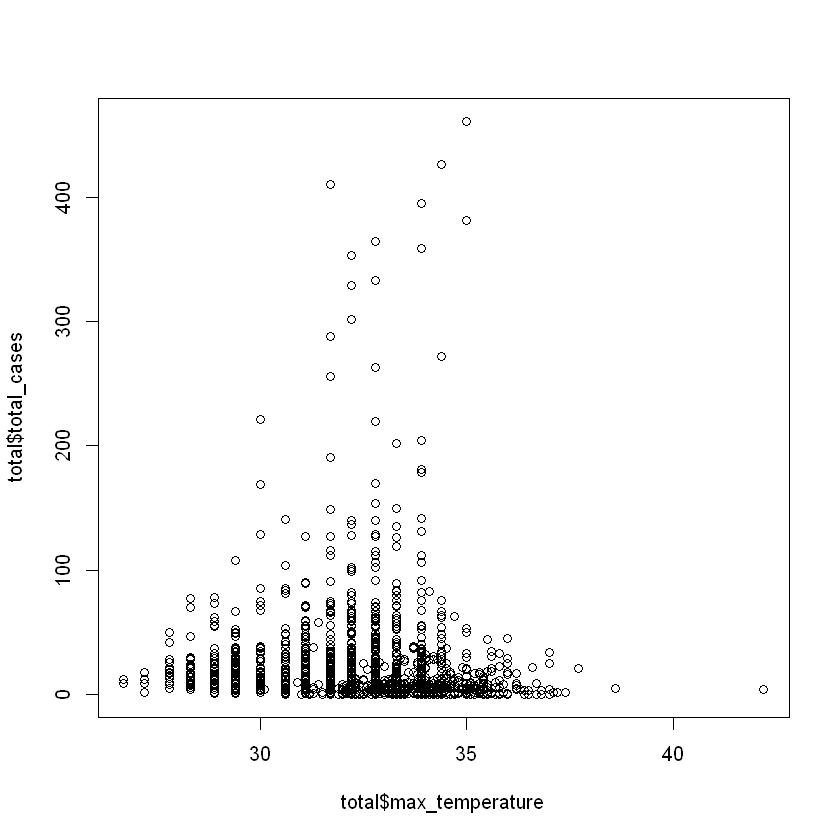

In [24]:
plot(x=total$max_temperature,y=total$total_cases)

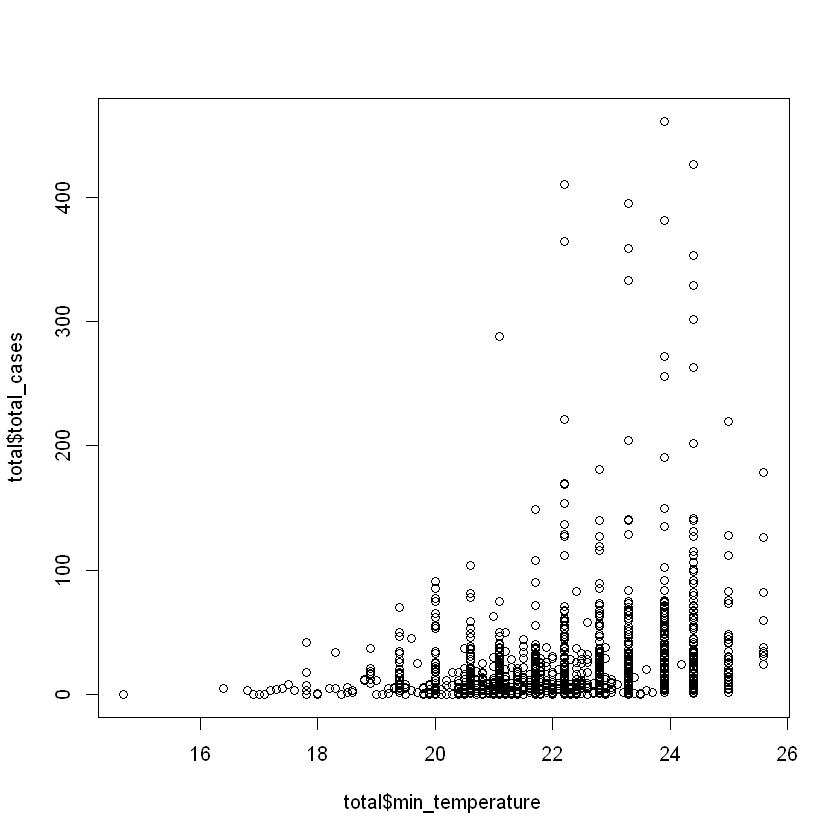

In [25]:
plot(x=total$min_temperature,y=total$total_cases)

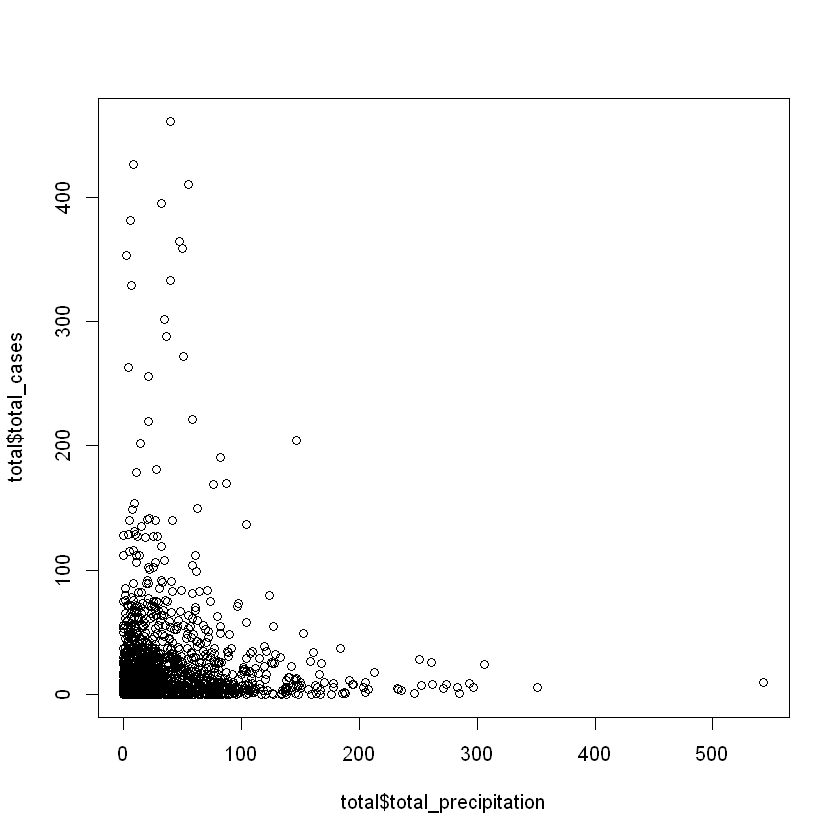

In [26]:
plot(x=total$total_precipitation,y=total$total_cases)

Create mosquito variable

In [27]:
total_mosquito <- ifelse(total$min_temperature >=20 & total$min_temperature <= 25,1,
                         ifelse(total$max_temperature >=25 & total$max_temperature <= 35,2,0))
test_mosquito <- ifelse(test$min_temperature >=20 & test$min_temperature <= 25,1,
                         ifelse(test$max_temperature >=25 & test$max_temperature <= 35,2,0))

In [28]:
total$mosquito <- as.factor(total_mosquito)
test$mosquito <- as.factor(test_mosquito)

Skewness of response variable

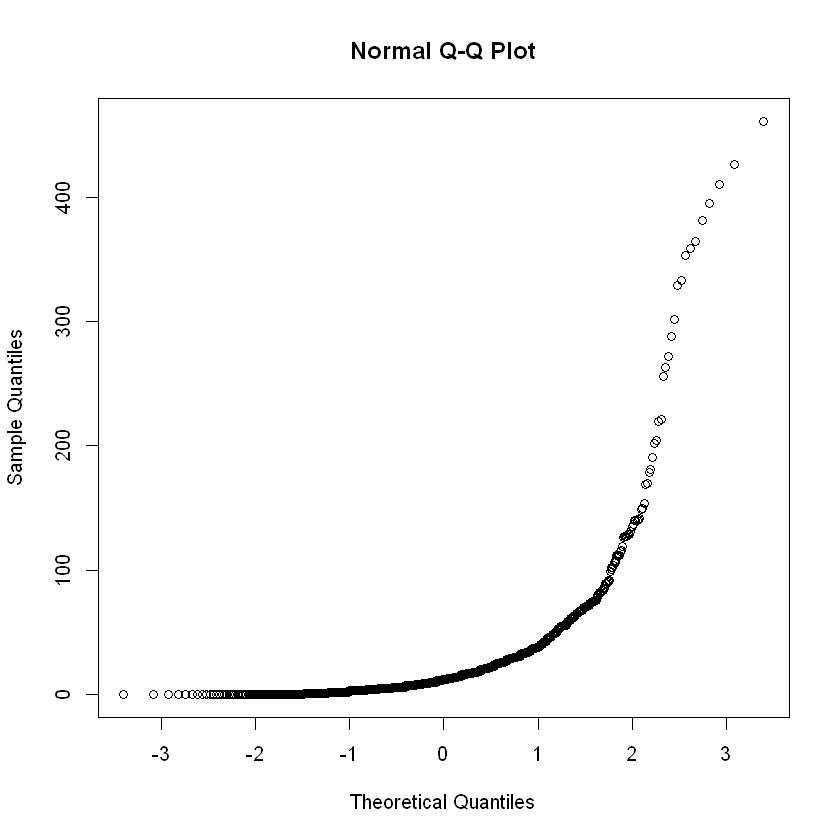

In [29]:
qqnorm(total$total_cases)

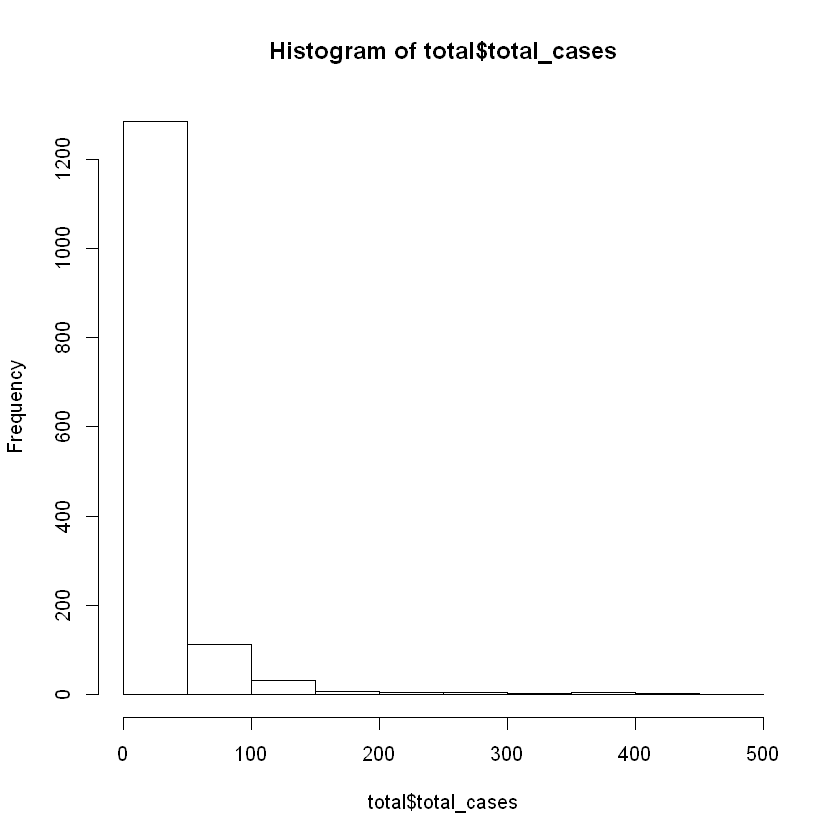

In [30]:
hist(total$total_cases,breaks=10)

In [31]:
total$total_cases <- log1p((total$total_cases))

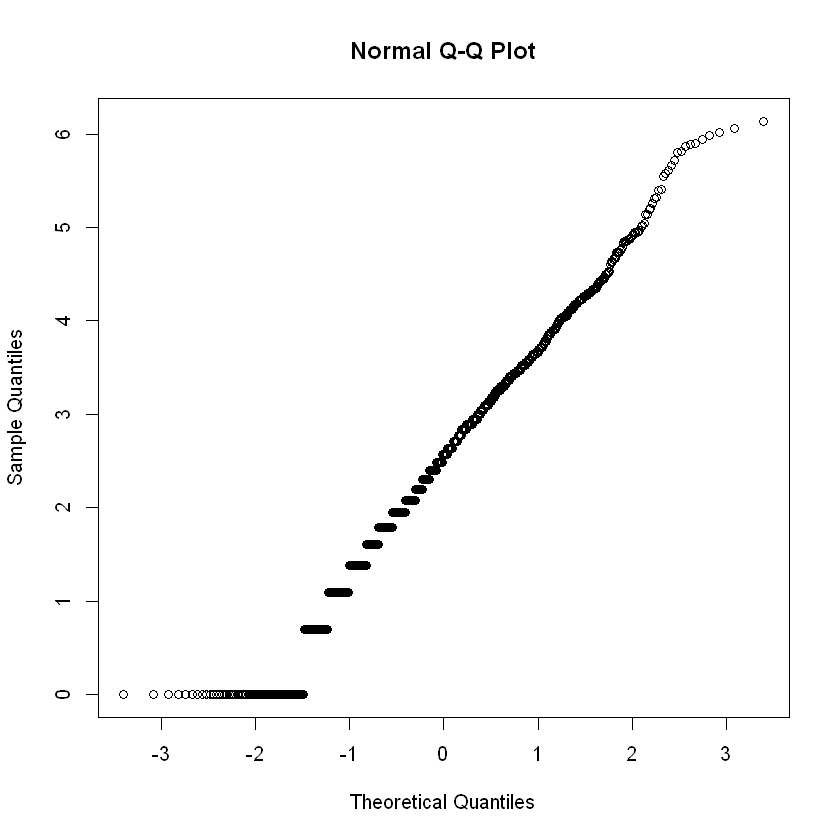

In [32]:
qqnorm(total$total_cases)

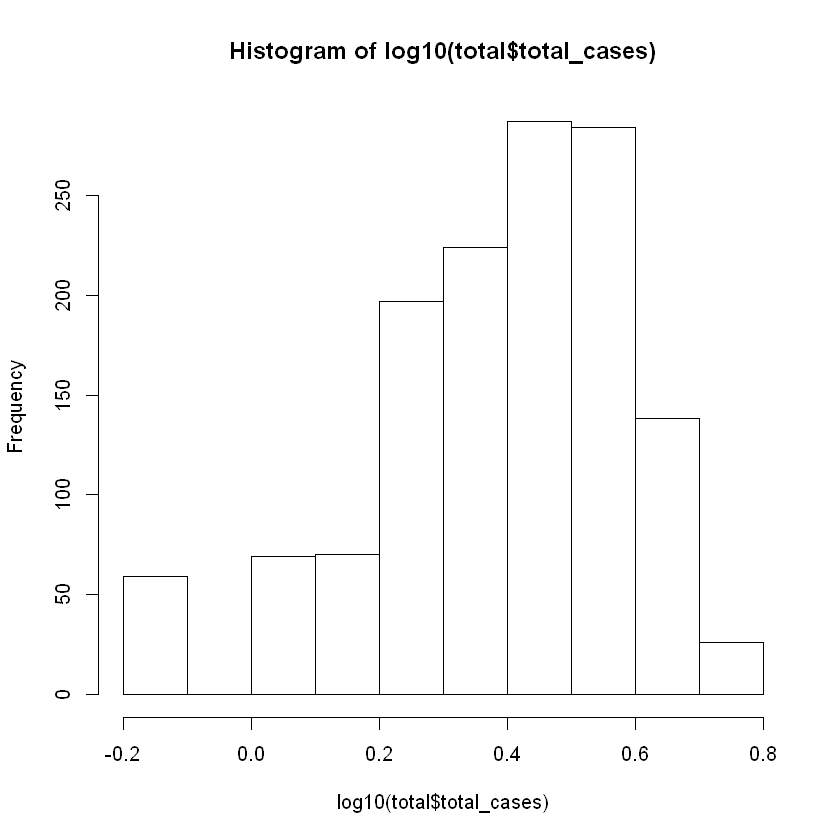

In [33]:
hist(log10(total$total_cases),breaks=10)

Set split (validation set as 30%)

In [34]:
total$year <- NULL
total$weekofyear <- as.factor(total$weekofyear)
total$week_start_date <- NULL
test$year <- NULL
test$weekofyear <- as.factor(test$weekofyear)
test$week_start_date <- NULL

In [35]:
features <- rbind(total[,-3],test)
X <- model.matrix(~.,data=features)
Y <- total$total_cases
X_training <- X[1:dim(total)[1],]

# x test set
X_test <- X[(dim(total)[1]+1):(dim(total)[1]+dim(test)[1]),]

In [36]:
n <- round(dim(total)[1]*0.7)
train.idx <- sample(1:nrow(X_training),n)
validation.idx <- setdiff(1:nrow(X_training),train.idx)

# test sets
X_all <- X_training
Y_all <- Y
X_train <- X_training[train.idx,]
Y_train <- Y[train.idx]
X_validation <- X_training[validation.idx,]
Y_validation <- Y[validation.idx]

In [ ]:
# PCA

In [75]:
X_all

,(Intercept),citysj,weekofyear2,weekofyear3,weekofyear4,weekofyear5,weekofyear6,weekofyear7,weekofyear8,weekofyear9,...,ndvi_se,ndvi_sw,precipitation_kgm2,relative_humidity,sat_precipitation,max_temperature,min_temperature,total_precipitation,mosquito1,mosquito2
1,1,0,0,0,0,0,0,0,0,0,...,0.3408857,0.24720000,43.19,92.41857,25.41,32.5,20.7,3.0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0.2894571,0.24165710,46.00,93.58143,60.61,34.0,20.8,55.6,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0.2041143,0.12801430,64.77,95.84857,55.52,33.0,20.7,38.1,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0.2542000,0.20031430,23.96,87.23429,5.60,31.5,14.7,30.0,0,1
5,1,0,0,0,0,0,0,0,0,0,...,0.2543714,0.36104290,31.80,88.16143,62.76,33.3,19.1,4.0,0,1
6,1,0,0,0,0,0,0,0,0,0,...,0.2316714,0.25531430,1.00,74.72857,16.24,32.0,17.0,11.5,0,1
7,1,0,0,0,0,0,0,0,0,0,...,0.3805857,0.38727140,26.68,83.27571,89.37,34.0,19.9,72.9,0,1
8,1,0,0,0,0,0,0,0,0,0,...,0.3417800,0.38275000,16.90,82.49000,42.08,33.0,20.5,50.1,1,0
9,1,0,0,0,0,0,0,0,0,0,...,0.4067143,0.30271430,5.59,74.74000,49.22,34.0,19.0,89.2,0,1
10,1,0,0,0,0,0,0,0,0,0,...,0.3146143,0.32425710,16.07,74.15143,53.65,34.0,20.0,78.0,1,0


# Create ML Models

LASSO, RIDGE

In [37]:
fm.lasso <- glmnet(X_all,Y_all,alpha=1)
fm.ridge <- glmnet(X_all,Y_all,alpha=0)

fm.lasso.cv <- cv.glmnet(X_all,Y_all,alpha= 1)
fm.ridge.cv <- cv.glmnet(X_all,Y_all,alpha= 0)

print(fm.lasso.cv)
print(fm.ridge.cv)


Call:  cv.glmnet(x = X_all, y = Y_all, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Measure      SE Nonzero
min 0.004042  0.8574 0.02616      58
1se 0.019654  0.8811 0.02698      51

Call:  cv.glmnet(x = X_all, y = Y_all, alpha = 0) 

Measure: Mean-Squared Error 

     Lambda Measure      SE Nonzero
min 0.06742  0.8790 0.02140      65
1se 0.15575  0.8979 0.02187      65


In [38]:
lambda_lasso <- fm.lasso.cv$lambda.min
lambda_ridge <- fm.ridge.cv$lambda.min

In [39]:
coef(fm.lasso.cv,lambda_lasso)

67 x 1 sparse Matrix of class "dgCMatrix"
                                1
(Intercept)         -5.9736181384
(Intercept)          .           
citysj               1.8883162428
weekofyear2          0.3607126031
weekofyear3          0.3553350117
weekofyear4          0.3198131872
weekofyear5          0.2247179641
weekofyear6          0.1381433852
weekofyear7          .           
weekofyear8          0.0222373266
weekofyear9          .           
weekofyear10        -0.2842685560
weekofyear11        -0.3461196512
weekofyear12        -0.4090562714
weekofyear13        -0.4914127609
weekofyear14        -0.7792896398
weekofyear15        -0.8212736958
weekofyear16        -0.7547265415
weekofyear17        -0.9041755995
weekofyear18        -0.8374611835
weekofyear19        -0.9099848921
weekofyear20        -0.9230792169
weekofyear21        -1.1015910198
weekofyear22        -0.7820781792
weekofyear23        -1.0107577381
weekofyear24        -0.8835168657
weekofyear25        -0.8080503393
weekof

In [40]:
coef(fm.ridge.cv,lambda_ridge)

67 x 1 sparse Matrix of class "dgCMatrix"
                                1
(Intercept)         -4.314899e+00
(Intercept)          .           
citysj               1.467800e+00
weekofyear2          4.730379e-01
weekofyear3          4.900052e-01
weekofyear4          4.446988e-01
weekofyear5          3.547824e-01
weekofyear6          2.630677e-01
weekofyear7          1.483936e-01
weekofyear8          1.544979e-01
weekofyear9          1.449055e-01
weekofyear10        -1.583534e-01
weekofyear11        -2.312966e-01
weekofyear12        -2.924413e-01
weekofyear13        -3.313304e-01
weekofyear14        -6.240941e-01
weekofyear15        -6.612324e-01
weekofyear16        -6.120372e-01
weekofyear17        -7.342200e-01
weekofyear18        -6.770982e-01
weekofyear19        -7.648239e-01
weekofyear20        -7.502738e-01
weekofyear21        -9.259823e-01
weekofyear22        -6.171245e-01
weekofyear23        -8.293514e-01
weekofyear24        -7.130616e-01
weekofyear25        -6.534608e-01
weekof

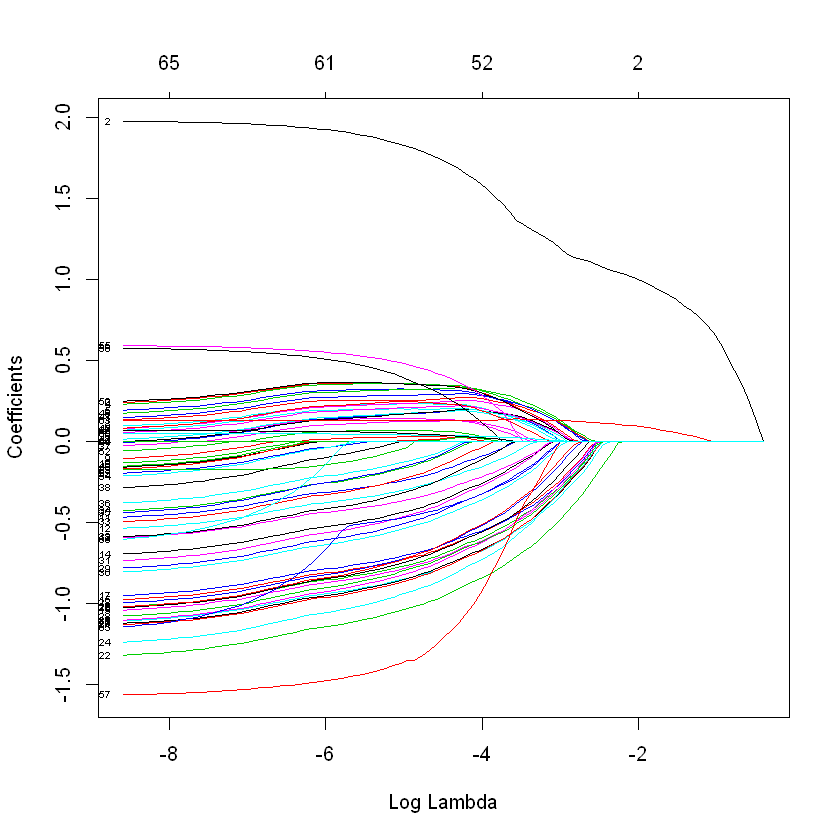

In [41]:
plot(fm.lasso,xvar="lambda",label=TRUE)

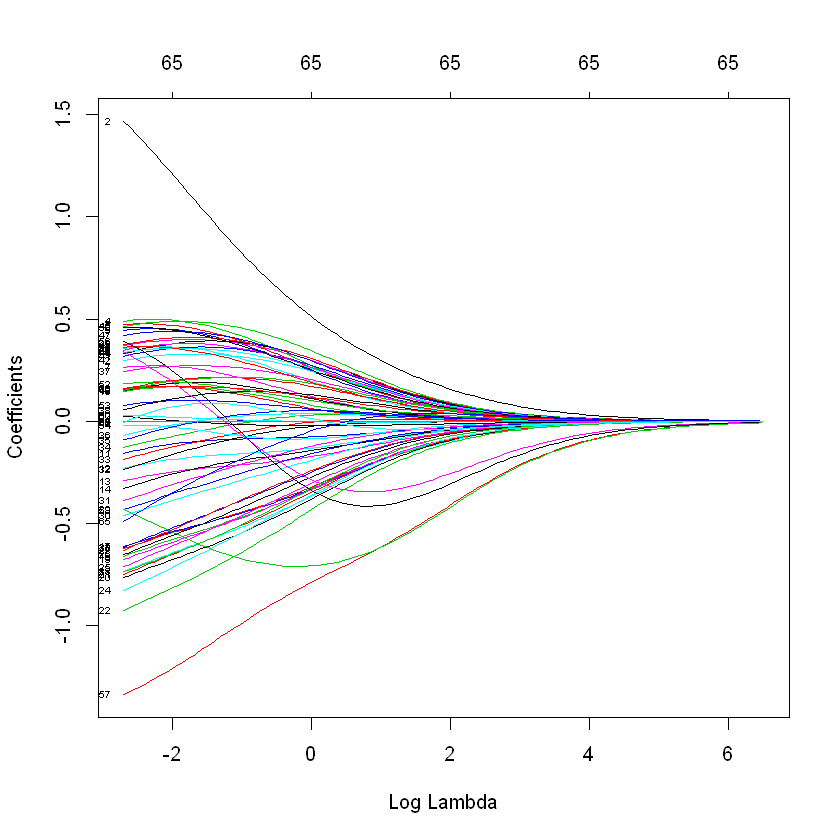

In [42]:
plot(fm.ridge,xvar="lambda",label=TRUE)

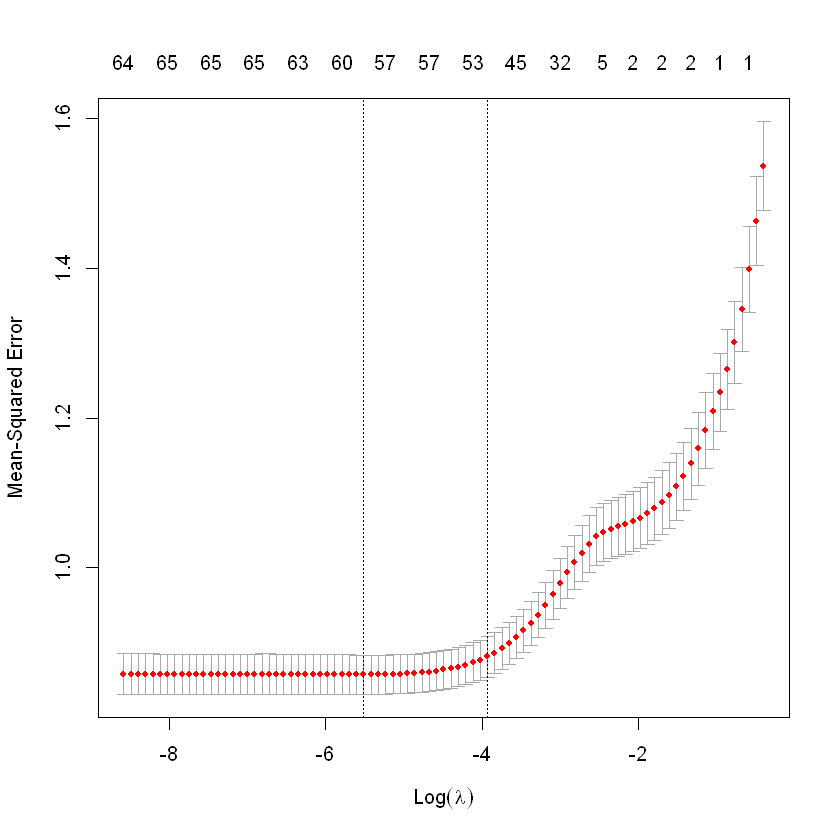

In [43]:
plot(fm.lasso.cv)

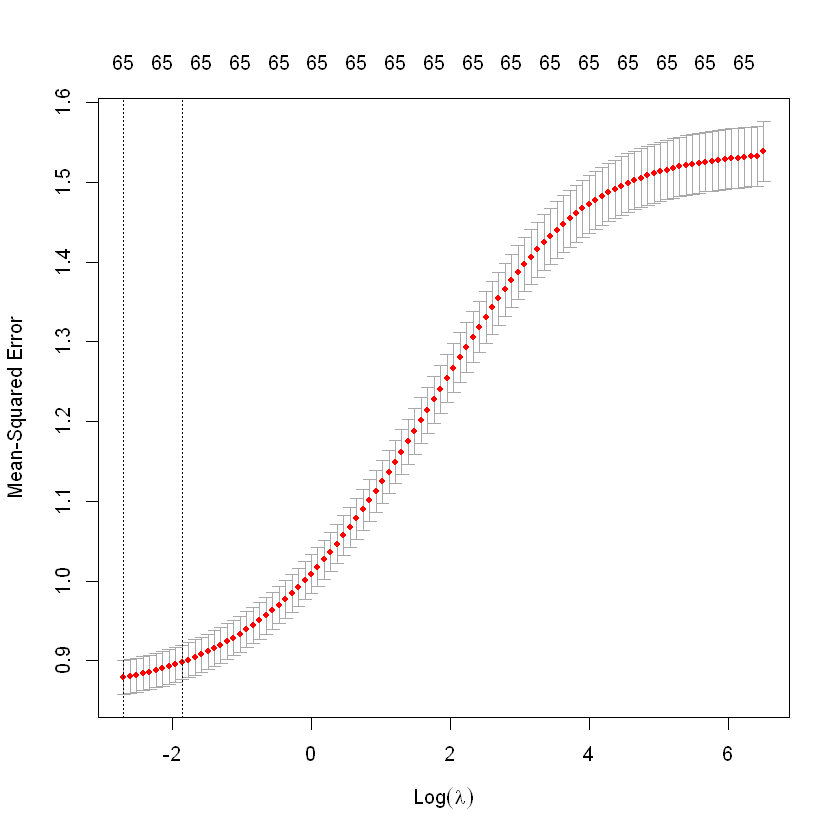

In [44]:
plot(fm.ridge.cv)

In [45]:
validation_lasso = predict(fm.lasso, newx = X_validation, s = lambda_lasso)
validation_ridge = predict(fm.ridge, newx = X_validation, s = lambda_ridge)

In [46]:
# mae of LASSO

In [47]:
MAE_lasso <- mean(abs((Y_validation-validation_lasso)))
print(MAE_lasso)

[1] 0.70846


In [48]:
# mae of RIDGE

In [49]:
MAE_ridge <- mean(abs((Y_validation-validation_ridge)))
print(MAE_ridge)

[1] 0.707906


Warning message in roc.default(Y_validation, validation_ridge):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 0, case = 0.693147180559945

Warning message in roc.default(Y_validation, validation_ridge):
"Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector."
Setting direction: controls < cases




Call:
roc.default(response = Y_validation, predictor = validation_ridge)

Data: validation_ridge in 27 controls (Y_validation 0) < 12 cases (Y_validation 0.693147180559945).
Area under the curve: 0.6512


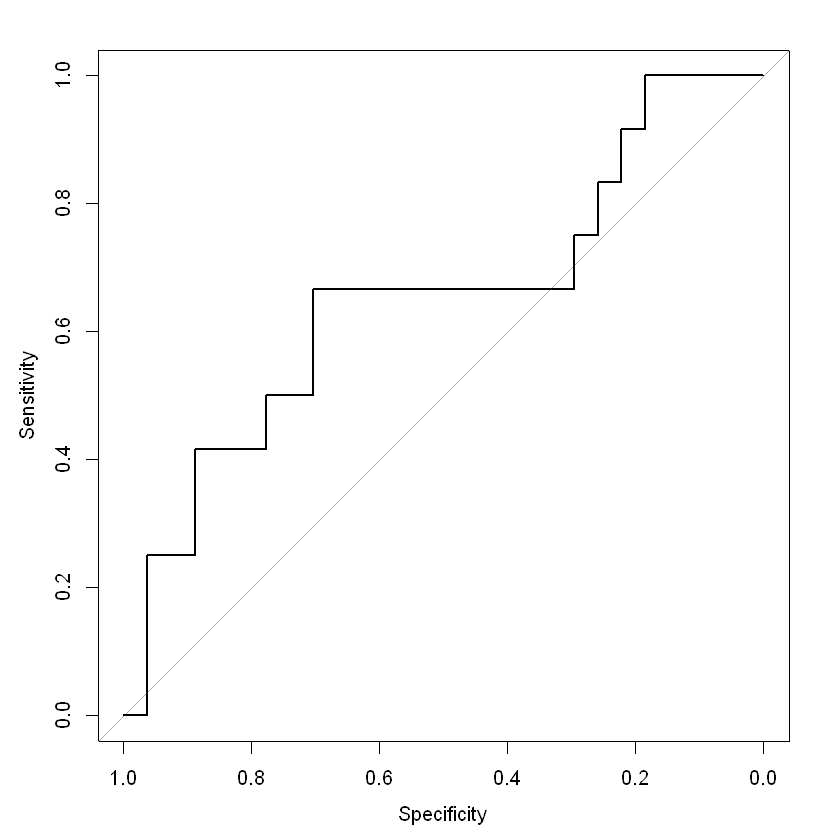

In [68]:
pROC_obj <- roc(Y_validation,validation_ridge)
print(pROC_obj)
plot(pROC_obj)

RANDOM FOREST

In [51]:
fit.rf <- randomForest(x=X_all,y=Y_all,do.trace=10, mtry=13, ntree=200,na.action=na.omit)
pred.rf  <- predict(fit.rf, newdata=X_validation)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
  10 |    1.167    75.96 |
  20 |    1.011    65.77 |
  30 |   0.9585    62.37 |
  40 |   0.9406    61.20 |
  50 |   0.9354    60.86 |
  60 |   0.9331    60.71 |
  70 |   0.9296    60.48 |
  80 |   0.9213    59.94 |
  90 |   0.9173    59.68 |
 100 |   0.9175    59.70 |
 110 |   0.9166    59.64 |
 120 |   0.9149    59.53 |
 130 |   0.9109    59.27 |
 140 |    0.909    59.14 |
 150 |   0.9086    59.12 |
 160 |   0.9078    59.07 |
 170 |   0.9086    59.12 |
 180 |   0.9076    59.06 |
 190 |   0.9067    59.00 |
 200 |   0.9067    59.00 |


In [52]:
# mae of Random Forest

In [66]:
mean(abs(pred.rf-Y_validation))

[1] 0.3328458

Warning message in roc.default(Y_validation, pred.rf):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 0, case = 0.693147180559945

Setting direction: controls < cases




Call:
roc.default(response = Y_validation, predictor = pred.rf)

Data: pred.rf in 27 controls (Y_validation 0) < 12 cases (Y_validation 0.693147180559945).
Area under the curve: 0.9846


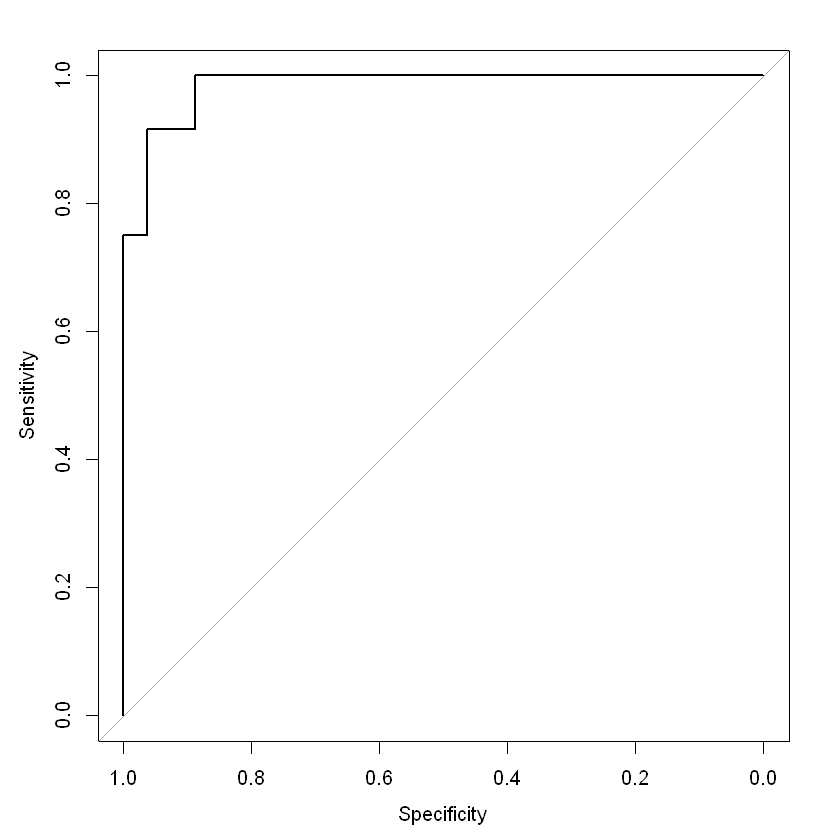

In [67]:
pROC_obj <- roc(Y_validation,pred.rf)
print(pROC_obj)
plot(pROC_obj)

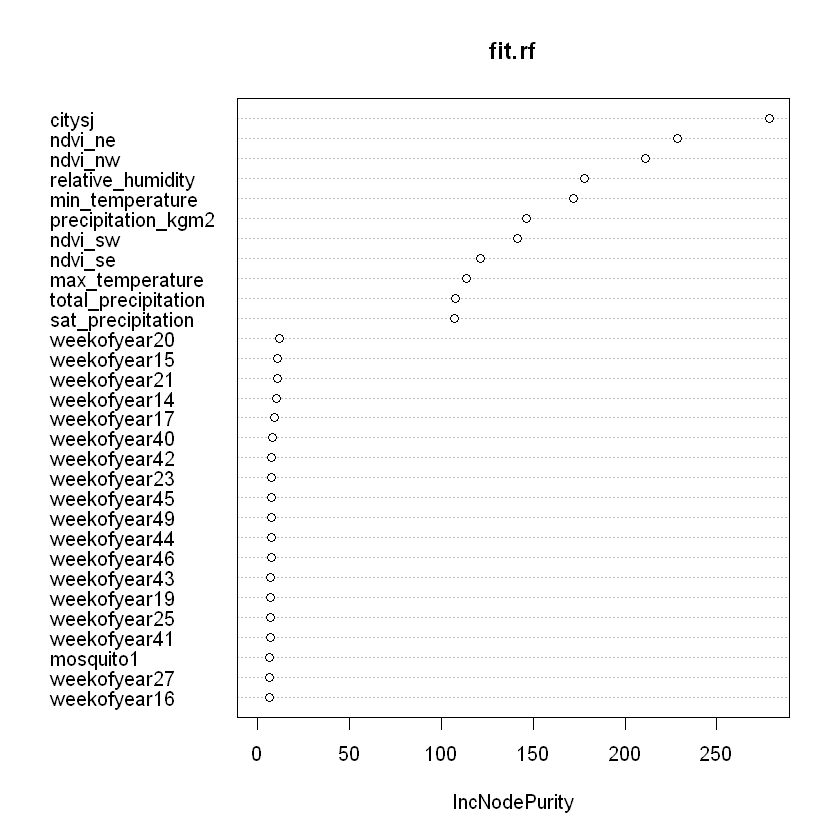

In [54]:
varImpPlot(fit.rf)

In [55]:
getTree(fit.rf,labelVar = TRUE)

,left daughter,right daughter,split var,split point,status,prediction
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,2,3,ndvi_ne,0.12917145,-3,2.4973608
2,4,5,citysj,0.50000000,-3,2.8975865
3,6,7,ndvi_ne,0.24523930,-3,1.9840416
4,8,9,weekofyear9,0.50000000,-3,1.3738649
5,10,11,ndvi_nw,-0.06931667,-3,2.9476709
6,12,13,citysj,0.50000000,-3,2.3025854
7,14,15,weekofyear34,0.50000000,-3,1.6394729
8,16,17,max_temperature,34.50000000,-3,1.2948374
9,0,0,NA,0.00000000,-1,2.3221954


Decision tree

In [56]:
fm.rpart <- rpart(Y_all~X_all)

In [57]:
print(fm.rpart)

n= 1454 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 1454 2234.60400 2.500030  
   2) X_allcitysj< 0.5 519  576.76420 1.595089  
     4) X_allprecipitation_kgm2< 24.03 130  119.39140 1.101955 *
     5) X_allprecipitation_kgm2>=24.03 389  415.19430 1.759889  
      10) X_allmin_temperature< 21.05 137  151.70850 1.420003 *
      11) X_allmin_temperature>=21.05 252  239.05510 1.944668 *
   3) X_allcitysj>=0.5 935  996.90110 3.002345  
     6) X_allmin_temperature< 23.6 647  641.51200 2.859564  
      12) X_allrelative_humidity< 79.63 426  370.46680 2.697670 *
      13) X_allrelative_humidity>=79.63 221  238.35750 3.171631  
        26) X_allndvi_ne< 0.21755 204  183.78180 3.075247 *
        27) X_allndvi_ne>=0.21755 17   29.93893 4.328241 *
     7) X_allmin_temperature>=23.6 288  312.56700 3.323108 *


In [58]:
printcp(fm.rpart)


Regression tree:
rpart(formula = Y_all ~ X_all)

Variables actually used in tree construction:
[1] X_allcitysj             X_allmin_temperature    X_allndvi_ne           
[4] X_allprecipitation_kgm2 X_allrelative_humidity 

Root node error: 2234.6/1454 = 1.5369

n= 1454 

        CP nsplit rel error  xerror     xstd
1 0.295774      0   1.00000 1.00140 0.035534
2 0.019163      1   0.70423 0.70676 0.024828
3 0.018875      2   0.68506 0.71286 0.025540
4 0.014628      3   0.66619 0.69674 0.024758
5 0.011025      4   0.65156 0.68953 0.024539
6 0.010933      5   0.64053 0.68346 0.024356
7 0.010000      6   0.62960 0.67862 0.024264


Call:
rpart(formula = Y_all ~ X_all)
  n= 1454 

          CP nsplit rel error    xerror       xstd
1 0.29577445      0 1.0000000 1.0014041 0.03553409
2 0.01916314      1 0.7042256 0.7067623 0.02482769
3 0.01887515      2 0.6850624 0.7128638 0.02554048
4 0.01462793      3 0.6661873 0.6967422 0.02475754
5 0.01102514      4 0.6515593 0.6895348 0.02453878
6 0.01093291      5 0.6405342 0.6834573 0.02435636
7 0.01000000      6 0.6296013 0.6786237 0.02426402

Variable importance
            X_allcitysj  X_allrelative_humidity            X_allndvi_ne 
                     23                      18                      16 
           X_allndvi_nw    X_allmax_temperature            X_allndvi_sw 
                     14                      11                      10 
   X_allmin_temperature X_allprecipitation_kgm2  X_allsat_precipitation 
                      3                       2                       1 

Node number 1: 1454 observations,    complexity param=0.2957744
  mean=2.50003, MSE

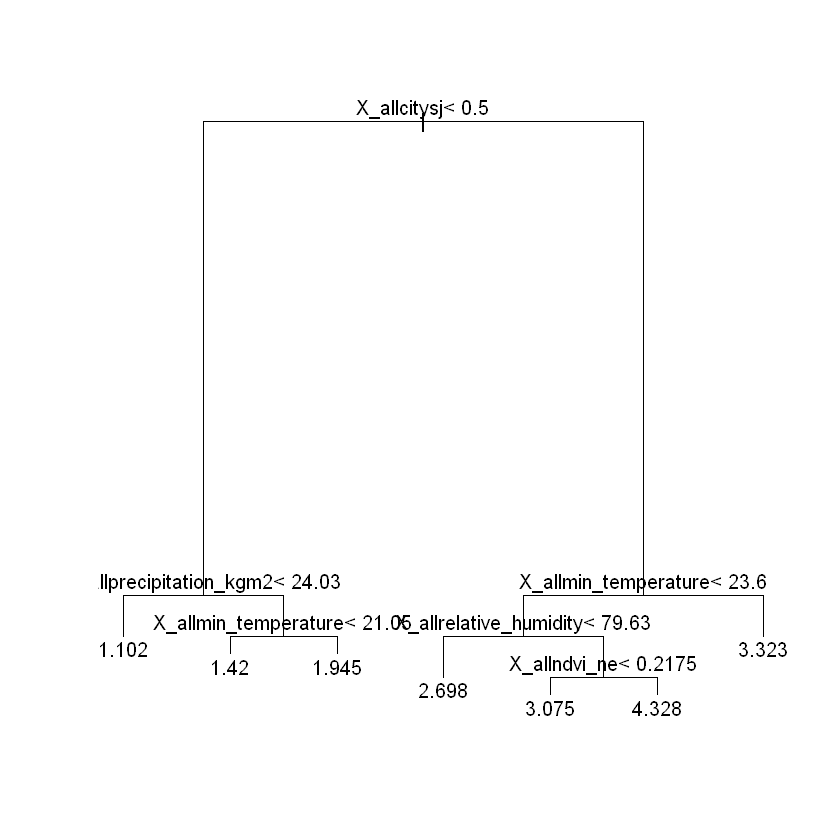

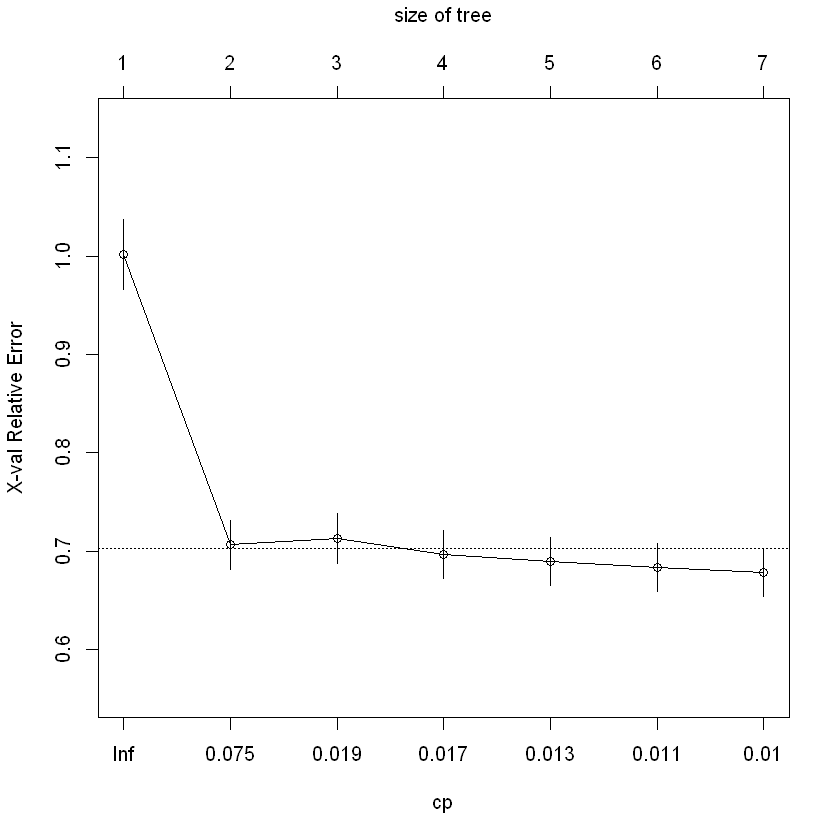

In [59]:
summary(fm.rpart)
plot(fm.rpart)
text(fm.rpart)
plotcp(fm.rpart)

# Prediction

In [60]:
prediction_lasso = predict(fm.lasso, newx = X_test, s = lambda_lasso)
prediction_ridge = predict(fm.ridge, newx = X_test, s = lambda_ridge)

In [61]:
pred.rf1 <- predict(fit.rf, newdata =X_test)

inverse exponential + 1

In [62]:
prediction = as.integer(round(exp(pred.rf1)+1))

In [63]:
final <- data.frame(submission,prediction,row.names = NULL)

In [64]:
colnames(final)[4]<-"total_cases"

In [65]:
write.csv(final,"submission.csv", row.names = FALSE)